In [2]:
# Imports and config

import warnings
from glob import glob
from pathlib import Path

import astropy.constants as constants
import astropy.units as u
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from lvm_lib.config.data_config import DataConfig
from lvm_lib.data.tile import LVMTile, LVMTileCollection
from lvm_lib.fit_data.builder import FitDataBuilder
from lvm_lib.fit_data.filtering import BAD_FLUX_THRESHOLD
from model import ConstrainedGaussian
from modelling_lib import (
    Constant,
    ConstrainedParameter,
    FourierGP,
    Kernel,
    Matern12,
    Matern32,
    OptimiserFrame,
    Parameter,
    PerSpaxel,
    SpectralSpatialModel,
    build_model,
)
from modelling_lib import SpatialDataGeneric as SpatialData
from numpy.random import default_rng
from optax import adam, lbfgs
from plots_lib import COLORS

rng = default_rng(0)
jax.config.update("jax_enable_x64", True)
plt.style.use("plots_lib.custom")
warnings.filterwarnings("ignore", message="All-NaN slice encountered")

# Example 1: ${\rm H \alpha}$ in Rosette

## Model specification

As a first example, let's fit a simple spatial + spectral model to the $\rm H\alpha$ line emission in the Rosette nebula. This example is intended to demonstrate the method in the high S/N regime.

Let's briefly outline the model. Let $F(\alpha_i, \delta_i, \lambda_j)$ be the flux in pixel $i,j$ with sky coordinates $\alpha_i, \delta_i$ and wavelength $\lambda_j$. The model can then be written compactly as
$$
F(\alpha_i, \delta_i, \lambda_j) = \frac{f_{F}(\alpha_i, \delta_i)}{f_{\sigma} (\alpha_i, \delta_i) \sqrt{2 \pi}} \exp{\left[ -\frac{1}{2}\left( \frac{\lambda_j - f_{\lambda0} (\alpha_i, \delta_i)}{f_{\sigma} (\alpha_i, \delta_i)}\right)^2\right]} + C_i + {\rm noise}
$$
where $C_i$ is a constant, per-spaxel offset parameter, and $f_{F}, f_{\lambda0}, f_{\sigma}$ are continuous functions that we are yet to specify. We will choose these functions to be spectral representations of Gaussian processes specified by the power spectral density of the chosen covariance function (more details in paper draft). We therefore have to fit for a bunch of coefficients of Fourier basis functions per function. The functions are then evaluated on the data locations using fiNUFFT. We also have to fit for the parameters of the covariance functions for each function.

We will also assume the noise is normally distributed although that isn't strictly required.

Using our framework built on `jax` and `equinox`, we can write this model simply as:

In [3]:
class LVMModel(SpectralSpatialModel):
    # Model components
    continuum: Constant  # not really meant to model the continuum since it's mostly for nuisance but it's like continuum *shrug*
    line: ConstrainedGaussian  # "Constrained" just means the amplitude and width are >0

    def __init__(
        self,
        n_spaxels: int,
        n_modes: tuple[int, int],
        A_kernel: Kernel,
        λ0_kernel: Kernel,
        σ_kernel: Kernel,
        offsets: Parameter,
    ):
        # Build the constant per-spaxel component
        self.continuum = Constant(
            const=PerSpaxel(
                n_spaxels=n_spaxels,
                spaxel_values=offsets,
            ),
        )
        # Build the emission line component
        self.line = ConstrainedGaussian(
            A=FourierGP(n_modes, A_kernel),
            λ0=FourierGP(n_modes, λ0_kernel),
            σ=FourierGP(n_modes, σ_kernel),
        )

    # Instructions for evaluating the model
    def __call__(self, λ, spatial_data):
        return self.continuum(λ, spatial_data) + self.line(λ, spatial_data)

Written this way, we can choose the kernels/covariance functions we want, how many modes to include and how many spaxels the model has, when we actually instantiate it.

## Data reading

Before that, let's read in the Rosette data/tiles. We'll use the cental-most 19 tiles centred on Rosette.

In [4]:
LINE_CENTRE = 6562.85  # Hα line centre in Angstroms


drp_files = glob("../../data/rosette/lvm*.fits")
λ_range = (LINE_CENTRE - 8, LINE_CENTRE + 8)

# Some nice objects for loading the data
tiles = LVMTileCollection.from_tiles([LVMTile.from_file(Path(f)) for f in drp_files])
# This config object lazily loads the data (for when things get big) and applyies some trimming/filtering as well as normalisation/scaling to help the fitting
# The data is loaded to memory temporarily for the sake of calculating scaling factors
config = DataConfig.from_tiles(
    tiles,
    λ_range,
    normalise_F_scale=1e-12,
    normalise_F_offset=-1e-14,
    F_range=(BAD_FLUX_THRESHOLD, 0.5e-13),
)
# F_range filters out spaxels where the median is very negative (bad sky subtraction) or very positive (stellar contamination)

# Convert the data into a nice form for the model
builder = FitDataBuilder(tiles, config)  # This can provide a hash for perfect reproducability
fd = builder.build()  # fd contains all the stuff we need for fitting, lazily loaded to ease memory use until we actually do optimisation

Plots to check things are ok

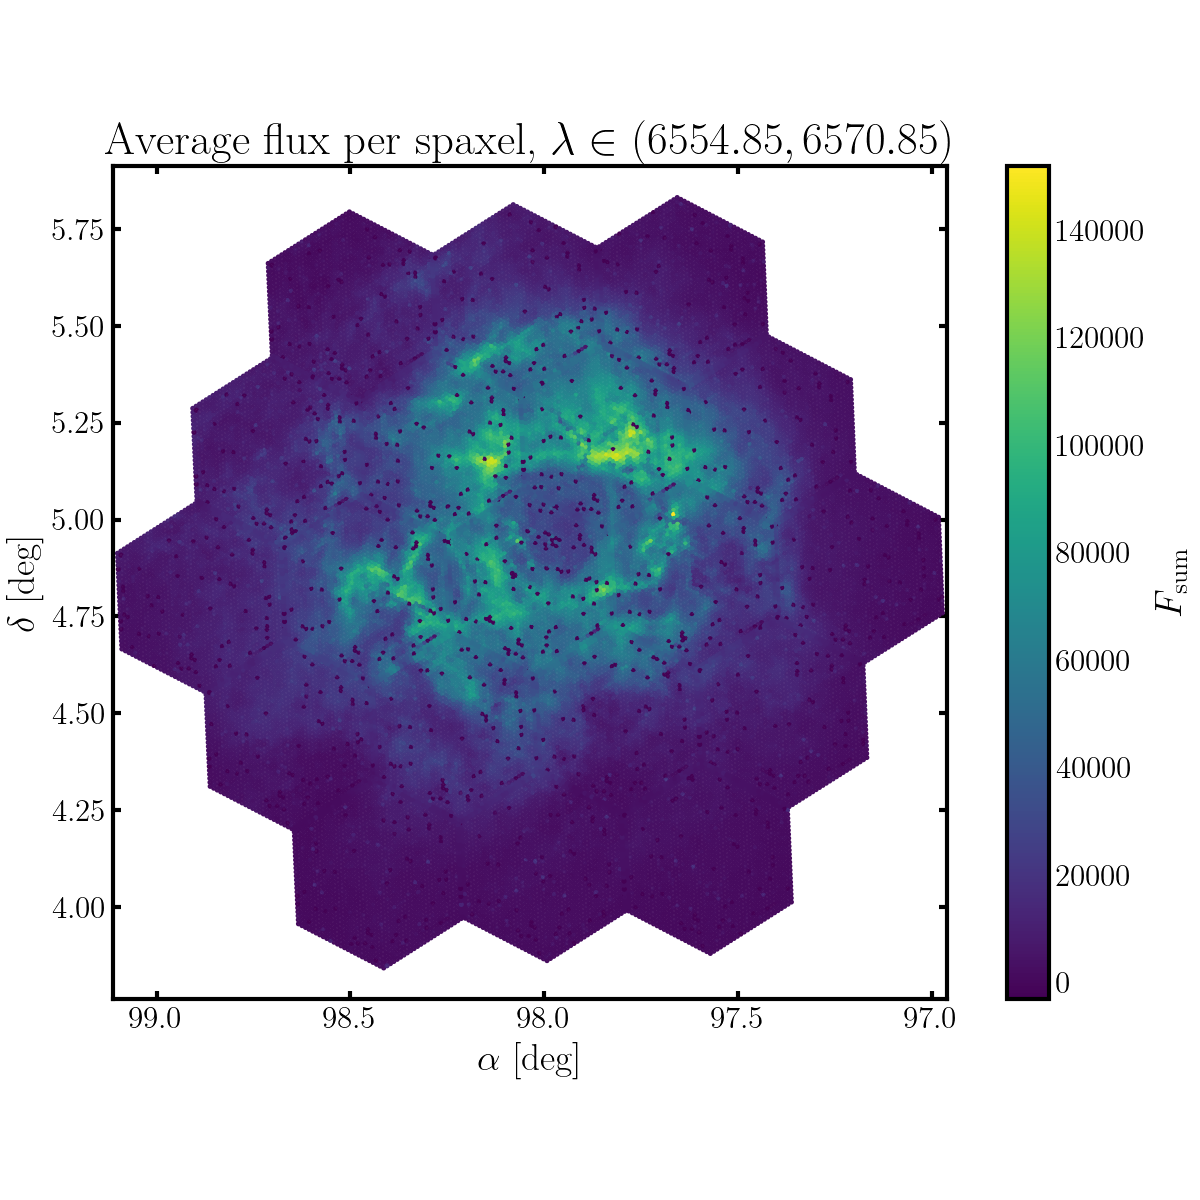

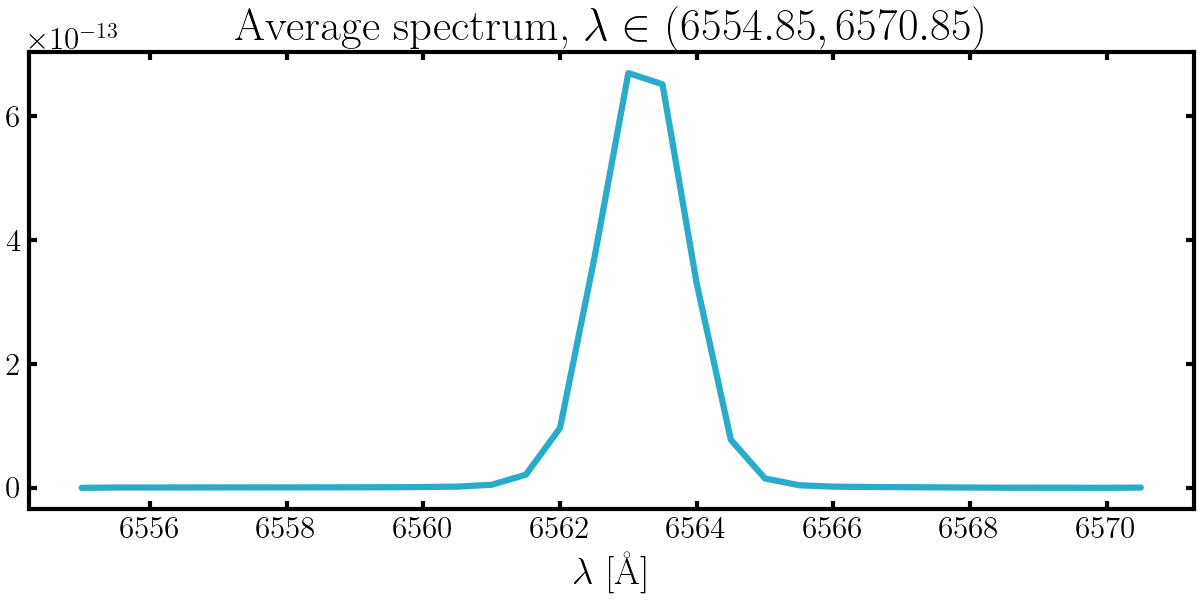

In [5]:
dλ = fd.λ[1] - fd.λ[0]

fig, ax = plt.subplots(figsize=[8, 8], layout="compressed", dpi=150)
ax.set_title(rf"Average flux per spaxel, $\lambda \in {λ_range}$")
# the "predict_x" functions unscale the coordinates to how they were originally for plotting or for comparison once we have model predictions
cs = ax.scatter(
    fd.predict_α(fd.α),
    fd.predict_δ(fd.δ),
    c=np.nansum(fd.predict_flux(fd.flux), axis=0) / (1e-16),
    s=0.9,
)
plt.colorbar(cs, ax=ax, label=r"$F_{\rm sum}$")
ax.set_aspect(1)
ax.set_xlabel(r"$\alpha$ [deg]")
ax.set_ylabel(r"$\delta$ [deg]")
ax.set_xlim(config.α_range[1], config.α_range[0])
ax.set_ylim(*config.δ_range)
plt.show()

fig, ax = plt.subplots(figsize=[8, 4], layout="compressed", dpi=150)
ax.set_title(rf"Average spectrum, $\lambda \in {λ_range}$")
ax.plot(fd.λ, np.nanmean(fd.predict_flux(fd.flux), axis=1))
ax.set_xlabel(r"$\lambda$ [${\rm \AA}$]")
plt.show()

Looks good. There's some missing/bad/filtered data, which we can query as:

In [6]:
# fd._flux has the bad data as nans. fd.flux replaces them with zeros so jax doesn't die
n_bad_spax = np.sum(np.all(np.isnan(fd._flux), axis=0))
n_bad_pix = np.sum(np.isnan(fd._flux))

print(f"no. missing spaxels = {n_bad_spax} / {len(fd.α)}")
print(f"no. missing pixels = {n_bad_pix} / {fd.flux.size}")

no. missing spaxels = 1164 / 34219
no. missing pixels = 40546 / 1095008


But that'll be fine. 

## Build the model

Let's instantiate/build our model now, including choosing our covariance structure and initialisation. 

We're going to choose to use the Matern-1/2 kernel for the line flux/peak (called A in the code) as well as the line redshift/blueshift (λ0). These two components will _share_ a length scale, but will have different variances. The line widths (σ) will have instead the Matern-3/2 kernel, and it's own length scale and variance.

We can set this up as follows. We'll also initialise the constant per-spaxel offsets while we're at it.

In [7]:
# We need enough modes to resolve small enough length scales. On the other hand, we don't want too many modes because it makes the optimisation harder and slower
# We will make a conservative "safe" choice here of 351 modes in each dimension for a total of 123,201 basis functions for each A, λ0, and σ
n_modes = (351, 351)  # 351 by 351 works
n_spaxels = len(fd.α)

# We give also some sensible initial guesses to help optimisation, and some bounds which mostly just enforce positivity
fix_kp = False
shared_length_scale = ConstrainedParameter(initial=1.0, fixed=fix_kp, lower=0.01, upper=5)
σ_length_scale = ConstrainedParameter(initial=0.6, fixed=fix_kp, lower=0.1, upper=5)
# It seems to help to start the line as too bright rather than too faint
A_variance = ConstrainedParameter(initial=0.2, fixed=fix_kp, lower=1e-5, upper=5)
λ0_variance = ConstrainedParameter(initial=1e-4, fixed=fix_kp, lower=1e-5, upper=5)
σ_variance = ConstrainedParameter(initial=0.01, fixed=fix_kp, lower=1e-5, upper=5)

# We give the same length scale to A and λ0 kernels, and the model will identify that we want it to be "shared"
A_kernel = Matern12(length_scale=shared_length_scale, variance=A_variance)
λ0_kernel = Matern12(length_scale=shared_length_scale, variance=λ0_variance)
σ_kernel = Matern32(length_scale=σ_length_scale, variance=σ_variance)

offsets = Parameter(dims=(n_spaxels,), fixed=False, initial=0.02 * np.ones(n_spaxels))

# Initialise the model
my_model = build_model(
    LVMModel,
    n_spaxels=n_spaxels,
    n_modes=n_modes,
    A_kernel=A_kernel,
    λ0_kernel=λ0_kernel,
    σ_kernel=σ_kernel,
    offsets=offsets,
)

# By default the Fourier coefficients are initialised to zero, as are the offsets
# But actually it works better to initialise the coefficients to draws from N(0, 1)
# We have a nice jax-y way to do this update in our framework:
# And we can also set the offsets to something slightly better than zero but in practice that doesn't really matter
my_model = my_model.set(
    [
        "line.A.coefficients",
        "line.λ0.coefficients",
        "line.σ.coefficients",
    ],
    [
        rng.standard_normal(n_modes),
        rng.standard_normal(n_modes),
        rng.standard_normal(n_modes),
    ],
)

# Save a "locked" copy of the initial model
init_model = my_model.get_locked_model()

We can check the structure of the model, including whether the parameter sharing between kernels is working, by plotting the "model graph" (not a probabilistic graphical model, just the component structure)

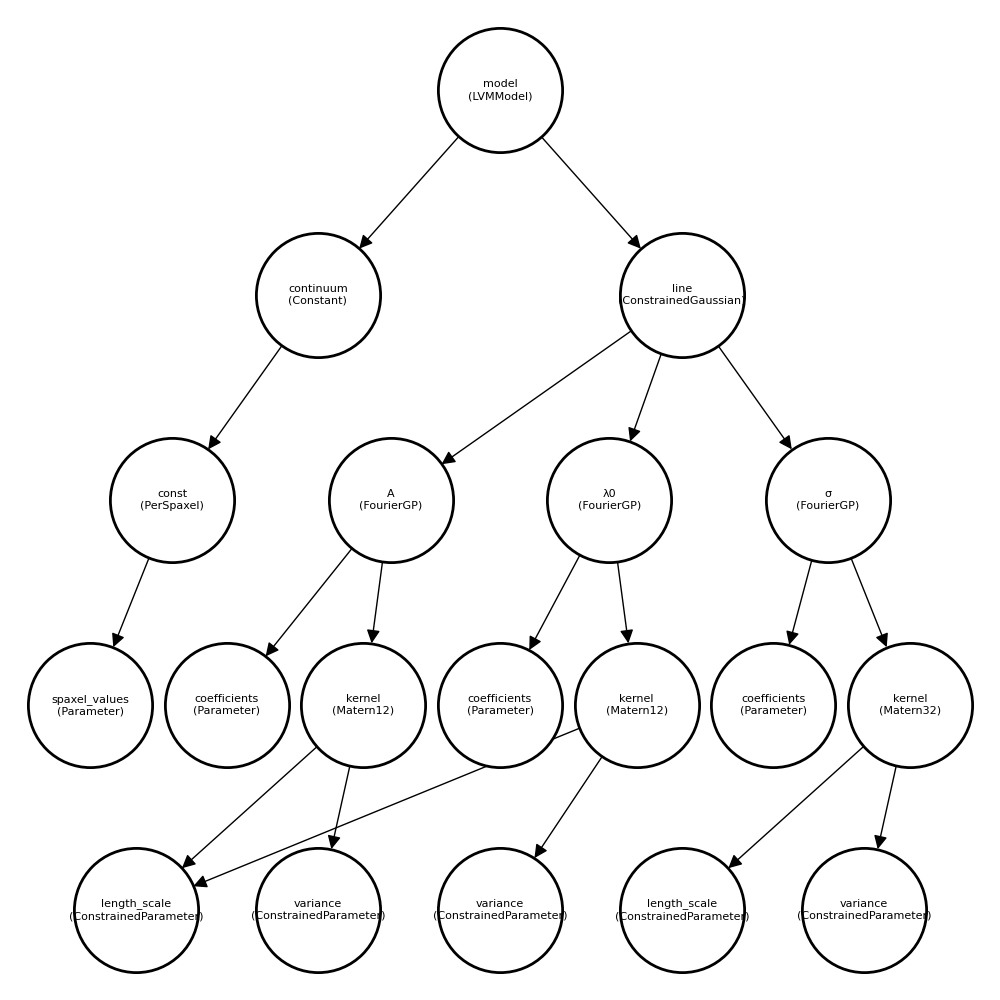

In [8]:
with plt.style.context("default"):
    my_model.plot_model_graph()

## Fitting

Next, we define our objective function and perform non-linear optimisation. The model is set up internally such that enforcing the GP stuff just means setting standard normal (μ=0, σ=1) priors on the Fourier coefficients.

In [9]:
def neg_ln_posterior(model, λ, xy_data, data, u_data, mask):
    # Model predictions
    pred = jax.vmap(model, in_axes=(0, None))(λ, xy_data)
    # Likelihood
    ln_like = jnp.sum(
        jnp.where(
            mask,
            jax.scipy.stats.norm.logpdf(x=pred, loc=data, scale=u_data),
            0.0,
        )
    )
    ln_prior = (
        model.line.A.prior_logpdf().sum()
        + model.line.λ0.prior_logpdf().sum()
        + model.line.σ.prior_logpdf().sum()
    )
    return -1 * (ln_like + ln_prior)

In [10]:
n_steps_1 = 1000
n_steps_2 = 1000

# Give our objective/loss function and the optimiser to an OptimiserFrame object
opt_frame_1 = OptimiserFrame(
    model=my_model,
    loss_fn=neg_ln_posterior,
    optimiser=lbfgs(),  # from optax
)

# First round of optimisation with lbfgs
opt_model = opt_frame_1.run(
    n_steps_1,
    λ=fd.λ - LINE_CENTRE,
    xy_data=fd.αδ_data,
    data=fd.flux,
    u_data=fd.u_flux,
    mask=fd.mask,
)

# Fix the kernel parameters now (my API doesn't have a neat way to do this yet, so we use equinox tree surgery instead)
opt_model = eqx.tree_at(lambda m: m.line.A.kernel.length_scale.fix, opt_model, True)
opt_model = eqx.tree_at(lambda m: m.line.λ0.kernel.length_scale.fix, opt_model, True)
opt_model = eqx.tree_at(lambda m: m.line.σ.kernel.length_scale.fix, opt_model, True)
opt_model = eqx.tree_at(lambda m: m.line.A.kernel.variance.fix, opt_model, True)
opt_model = eqx.tree_at(lambda m: m.line.λ0.kernel.variance.fix, opt_model, True)
opt_model = eqx.tree_at(lambda m: m.line.σ.kernel.variance.fix, opt_model, True)

# New frame for the second round of optimisation with adam
opt_frame_2 = OptimiserFrame(
    model=opt_model,
    loss_fn=neg_ln_posterior,
    optimiser=adam(0.2),  # from optax
)

opt_model = opt_frame_2.run(
    n_steps_2,
    λ=fd.λ - LINE_CENTRE,
    xy_data=fd.αδ_data,
    data=fd.flux,
    u_data=fd.u_flux,
    mask=fd.mask,
)

loss_history = opt_frame_1.loss_history + opt_frame_2.loss_history

# Get a locked model for making predictions
pred_model = opt_model.get_locked_model()

optimising: 100%|██████████| 1000/1000 [00:29<00:00, 33.39it/s]


Nice! Let's plot the objective function to check things went ok:

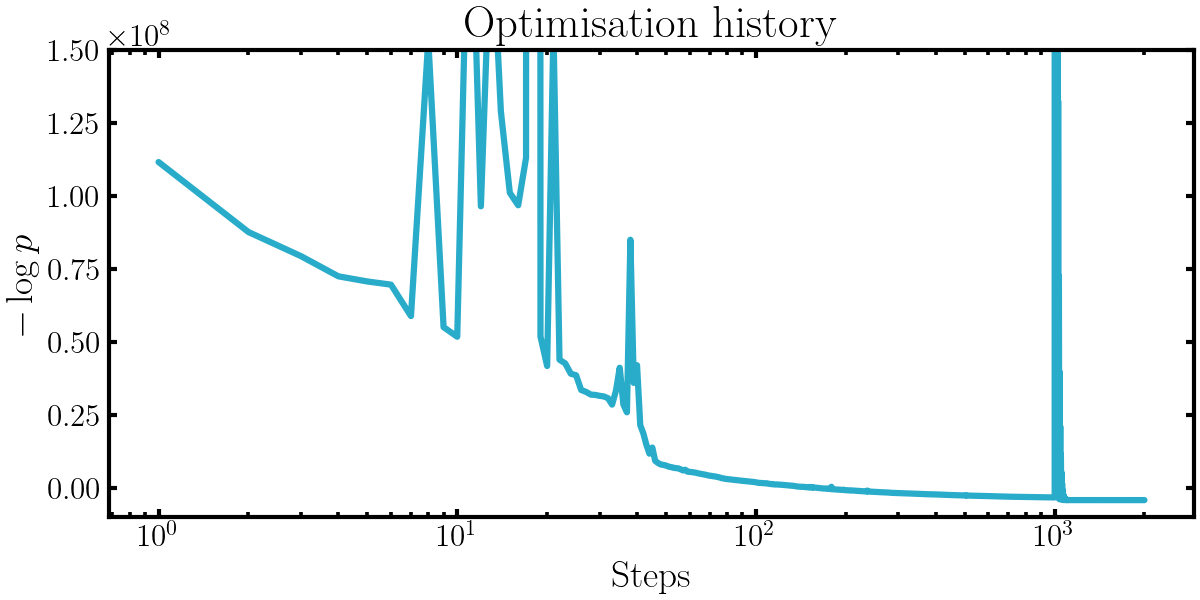

In [11]:
fig, ax = plt.subplots(figsize=[8, 4], layout="compressed", dpi=150)
ax.set_xlabel("Steps")
ax.set_ylabel(r"$-\log{p}$")
ax.plot(np.arange(1, len(loss_history) + 1), loss_history)
ax.set_title("Optimisation history")
ax.set_xscale("log")
plt.ylim(-1e7, 1.5e8)
plt.show()

There's some funky looking stuff in there, especially when we switch to the first order optimiser at 1000 steps, but we'll see that it's fine in the end.

## Model predictions

Let's check out the model predictions starting from the coolest plot, which is a plot of the smooth line properties $f_{F}, f_{\lambda0}, f_{\sigma}$ or A, λ0 and σ in the code. This is as easy as just evaluating those components of the model on a dense grid:

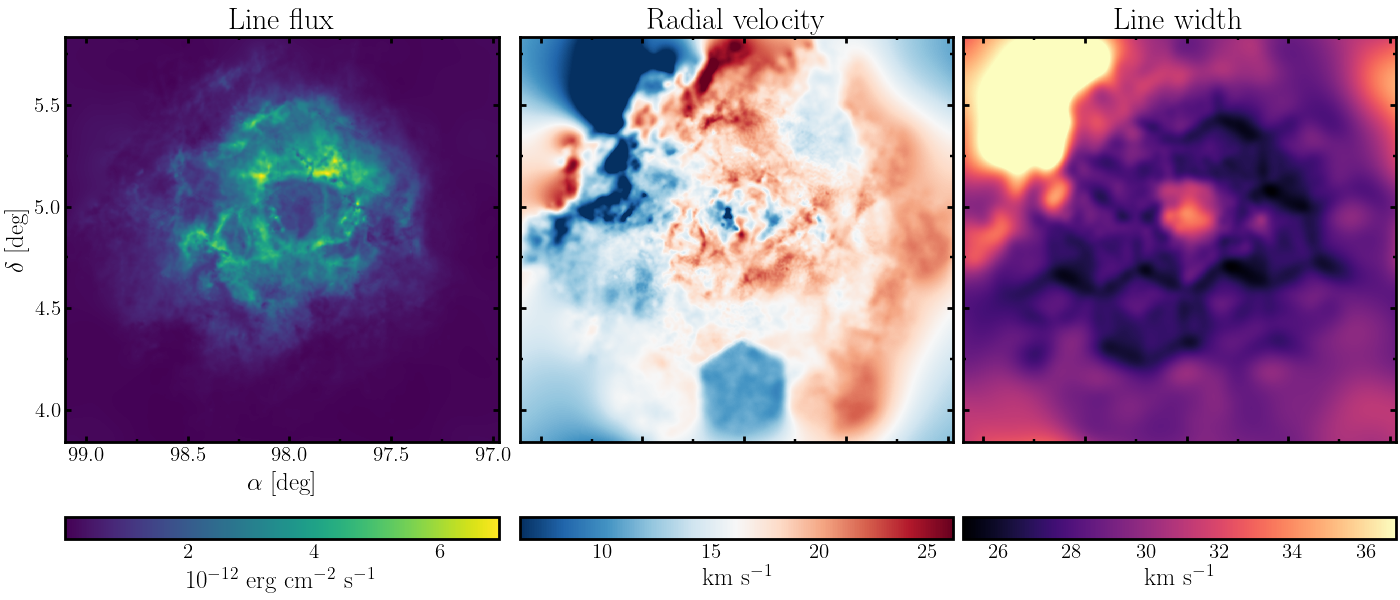

In [13]:
n_dense = 1200
α_dense_1D = np.linspace(fd.α.min(), fd.α.max(), n_dense)
δ_dense_1D = np.linspace(fd.δ.min(), fd.δ.max(), n_dense)

α_dense, δ_dense = np.meshgrid(α_dense_1D, δ_dense_1D)
# SpatialData is just a convenience object for some of the jax stuff
αδ_dense = SpatialData(
    α_dense.flatten(),
    δ_dense.flatten(),
    idx=np.arange(n_dense**2, dtype=int),
)

# Predict the model on a dense grid ("positive" gives us the model subject to the positivity constraints on A and σ)
A_pred = pred_model.line.A_positive(αδ_dense).reshape((n_dense, n_dense))
λ0_pred = pred_model.line.λ0(αδ_dense).reshape((n_dense, n_dense))
σ_pred = pred_model.line.σ_positive(αδ_dense).reshape((n_dense, n_dense))

# Convert things to original/useful units
α_plot = fd.predict_α(α_dense)
δ_plot = fd.predict_δ(δ_dense)
A_plot = fd.predict_flux(A_pred)
λ0_plot = (np.array(λ0_pred / LINE_CENTRE) * constants.c).to(u.km / u.s).value
σ_plot = (np.array(σ_pred / LINE_CENTRE) * constants.c).to(u.km / u.s).value

fig, ax = plt.subplots(1, 3, figsize=[14, 6], layout="compressed", dpi=100)

pcolormesh_kwargs = dict(shading="auto", rasterized=True, aa=True)

# Line flux
ax[0].set_title("Line flux")
c0 = ax[0].pcolormesh(α_plot, δ_plot, A_plot / 1e-12, cmap="viridis", **pcolormesh_kwargs)
ax[1].set_title(r"Radial velocity")
c1 = ax[1].pcolormesh(
    α_plot,
    δ_plot,
    λ0_plot,
    cmap="RdBu_r",
    vmin=np.median(λ0_plot) - 10,
    vmax=np.median(λ0_plot) + 10,
    **pcolormesh_kwargs,
)
ax[2].set_title(r"Line width")
c2 = ax[2].pcolormesh(
    α_plot,
    δ_plot,
    σ_plot,
    cmap="magma",
    vmin=σ_plot.min(),
    vmax=np.median(σ_plot) + 8,
    **pcolormesh_kwargs,
)

for i, a in enumerate(ax.flatten()):
    a.set_aspect(1)
    a.set_xlim(α_plot.max(), α_plot.min())
    a.set_axisbelow(False)
    if i != 0:
        a.set_xticklabels([])
        a.set_yticklabels([])
    # Set major ticks every half degree using automatic locator
    a.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    a.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    # Set minor ticks every 0.25 degree
    a.xaxis.set_minor_locator(plt.MultipleLocator(0.25))
    a.yaxis.set_minor_locator(plt.MultipleLocator(0.25))

ax[0].set_xlabel(r"$\alpha$ [deg]")
ax[0].set_ylabel(r"$\delta$ [deg]")

colorbar_kwargs = dict(location="bottom", pad=0.05)
plt.colorbar(c0, ax=ax[0], **colorbar_kwargs, label=r"$10^{-12}$ erg cm$^{-2}$ s$^{-1}$")
plt.colorbar(c1, ax=ax[1], **colorbar_kwargs, label=r"km s$^{-1}$")
plt.colorbar(c2, ax=ax[2], **colorbar_kwargs, label=r"km s$^{-1}$")

plt.savefig("H_alpha_rosette.pdf", bbox_inches="tight", dpi=300)
plt.show()

Cool! Looks pretty good. Especially the line flux/peak.

There is a couple funky things:
- In the RV plot, there is a big blue hexagon done the bottom. This is because the DRP does not do a barycentric correction, we haven't accounted for it, and that bottom tile was taken a few days apart from the others! Our lack of correction is also why the velocities are not centred at zero.
- In the line width plot, the lsf variations between the 3 spectrographs is a visible repeating pattern across the tiles that basically dominates the result. We didn't model any lsf variation, just a total line width, so this is expected.
- In both the RV and line widths plots, the predictions outside the data domain can go crazy, especially in the top left. You shouldn't mistake this for the model being bad, there just isn't any data there (or rather we didn't include it) to constrain the model!

Next we compare some individual spectra to the fit. We just pick some random fibres and compare.

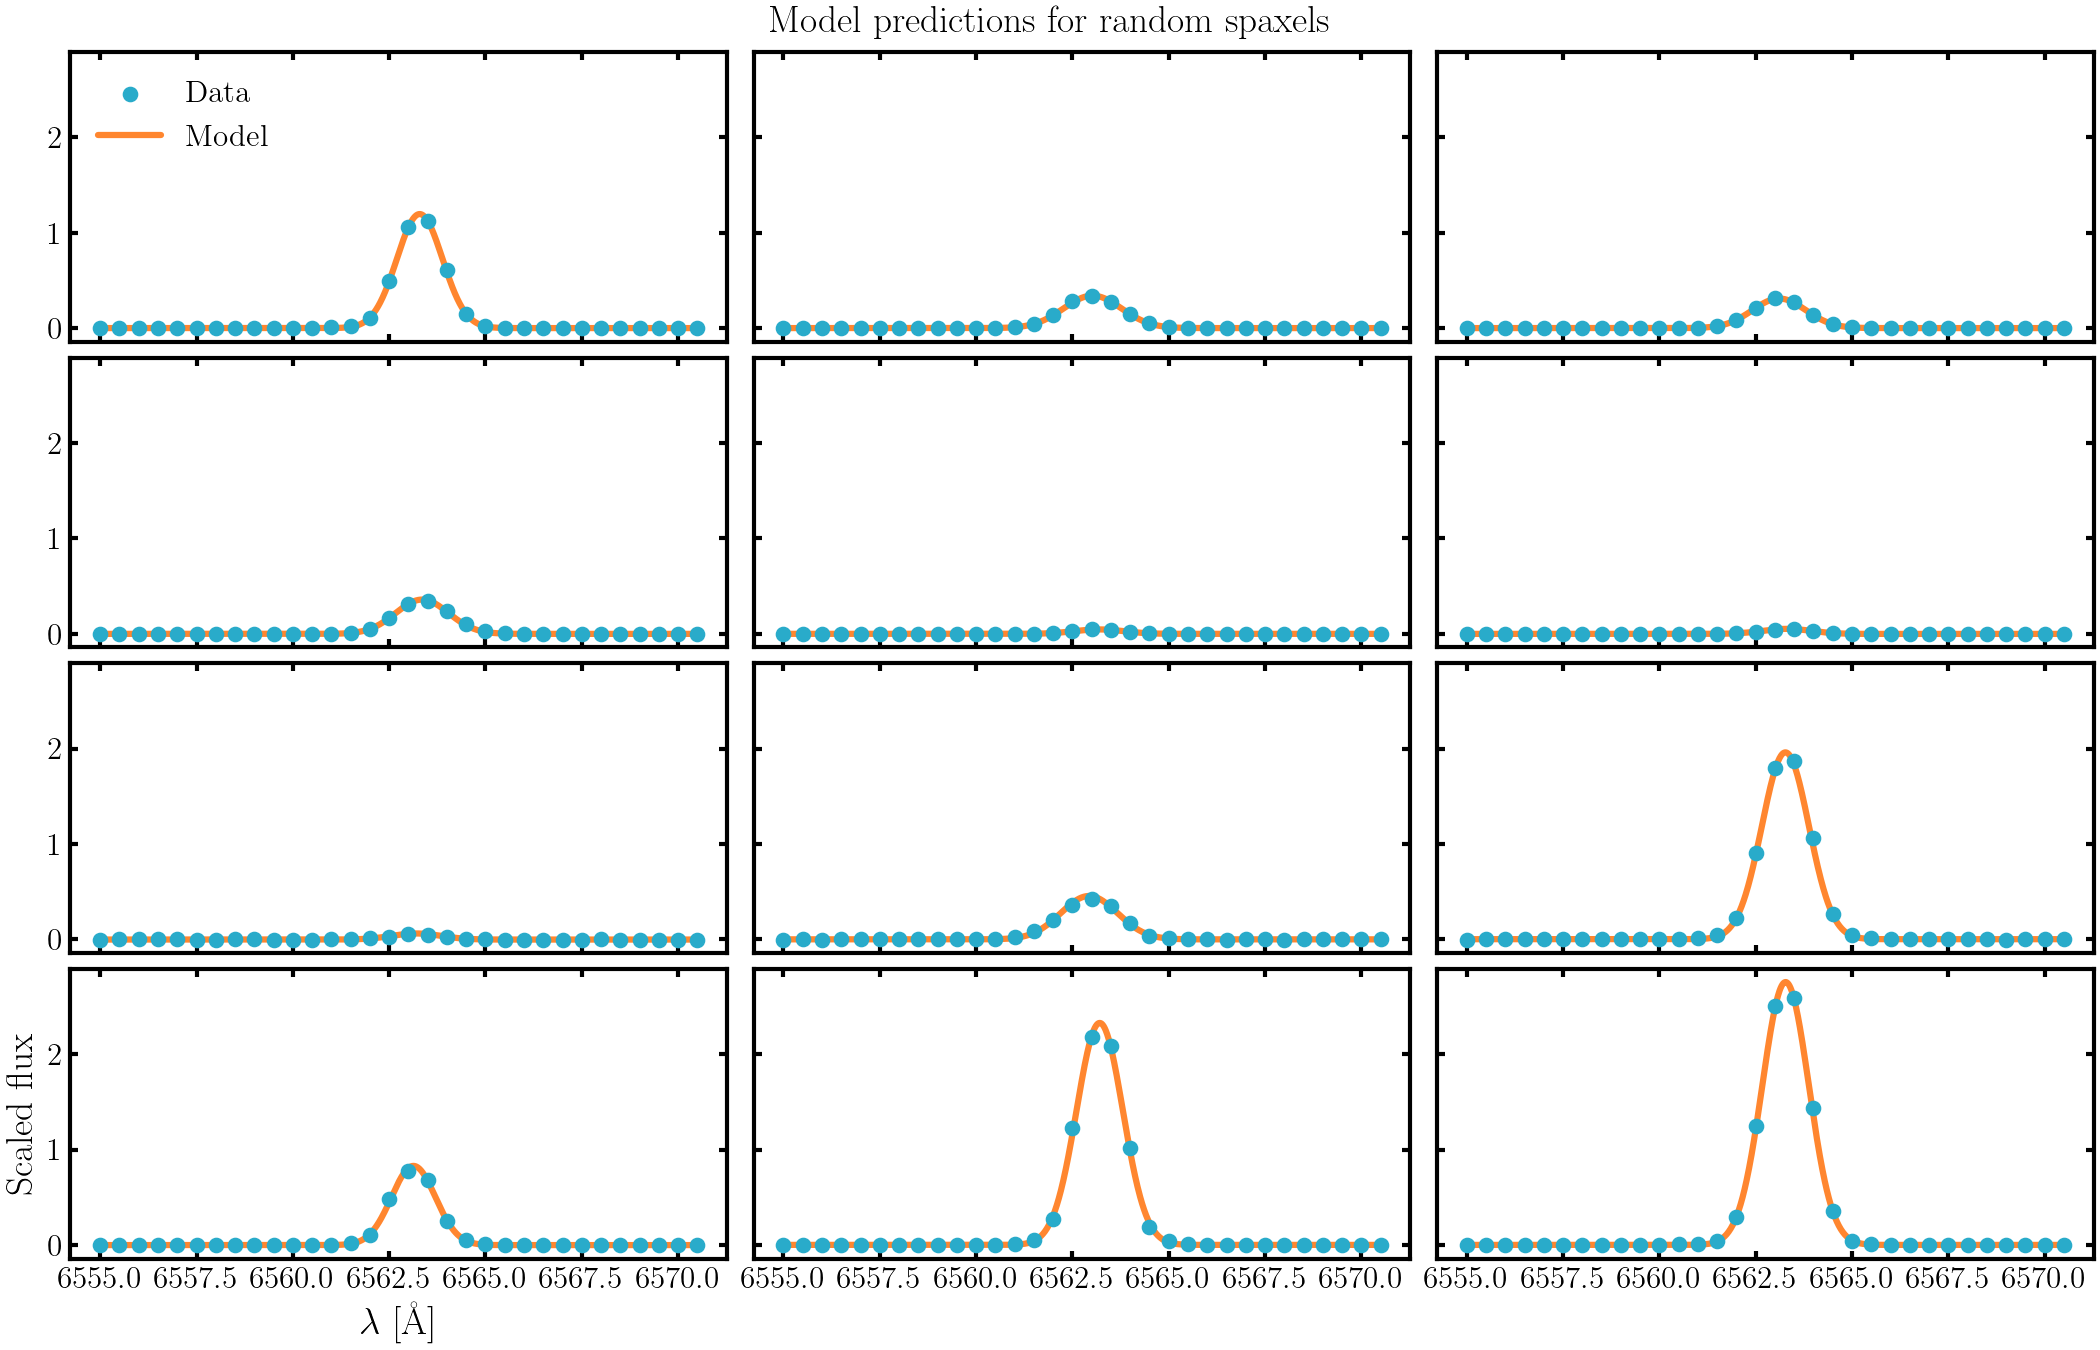

In [14]:
λ_dense = np.linspace(fd.λ.min(), fd.λ.max(), n_dense) - LINE_CENTRE
plot_λ = λ_dense + LINE_CENTRE

# We need to use vmap to vectorise over the wavelengths
pred_flux = jax.vmap(pred_model, in_axes=(0, None))(λ_dense, fd.αδ_data)
pred_flux = fd.predict_flux(pred_flux)

fig, ax = plt.subplots(
    4, 3, figsize=[14, 9], layout="compressed", sharex=True, sharey=True, dpi=150
)

ax_flat = ax.flatten()

for i, j in enumerate(rng.choice(n_spaxels, 12, replace=False)):
    # Make model predictions for the j-th spaxel

    norm = 1e-12
    ax_flat[i].scatter(fd.λ, fd.predict_flux(fd._flux[:, j]) / norm, zorder=1, label="Data")
    ax_flat[i].plot(plot_λ, pred_flux[:, j] / norm, c=COLORS[1], zorder=0, label="Model")

ax[0, 0].legend(loc="upper left", frameon=False)

ax[-1, 0].set_xlabel(r"$\lambda$ [${\rm \AA}$]")
ax[-1, 0].set_ylabel(r"Scaled flux")

fig.suptitle("Model predictions for random spaxels")


plt.show()

We should also do residuals

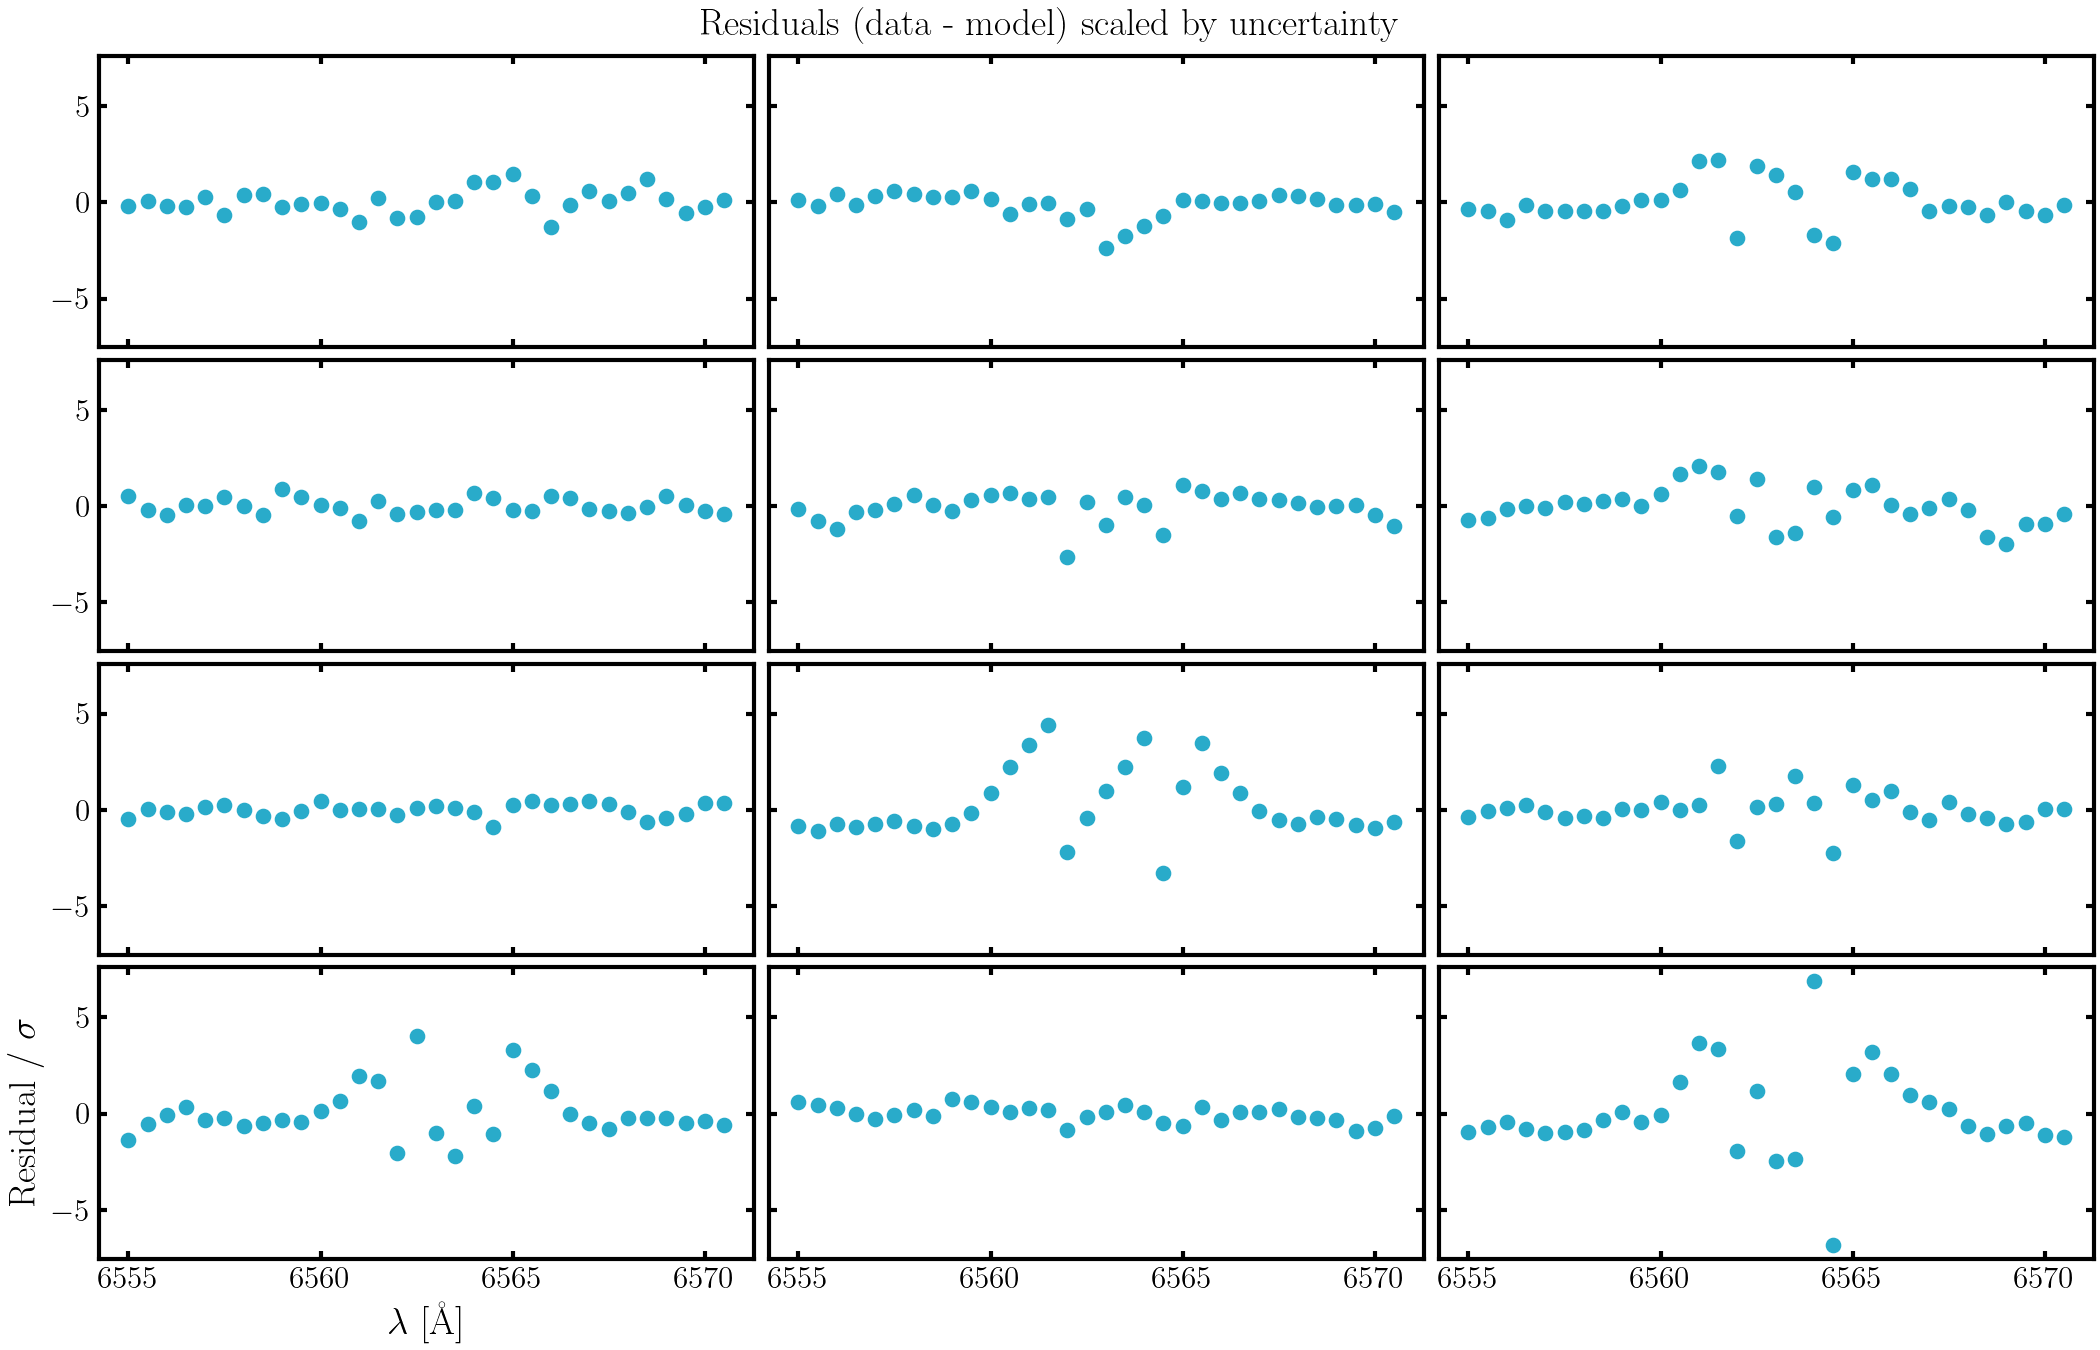

In [15]:
# We need to use vmap to vectorise over the wavelengths
pred_flux = jax.vmap(pred_model, in_axes=(0, None))(fd.λ - LINE_CENTRE, fd.αδ_data)
pred_flux = fd.predict_flux(pred_flux)

fig, ax = plt.subplots(
    4, 3, figsize=[14, 9], layout="compressed", sharex=True, sharey=True, dpi=150
)

ax_flat = ax.flatten()

for i, j in enumerate(rng.choice(n_spaxels, 12, replace=False)):
    ax_flat[i].scatter(
        fd.λ,
        (fd.predict_flux(fd._flux[:, j]) - pred_flux[:, j])
        * fd.predict_ivar(fd._i_var[:, j]) ** 0.5,
        zorder=1,
    )

ax[-1, 0].set_xlabel(r"$\lambda$ [${\rm \AA}$]")
ax[-1, 0].set_ylabel(r"Residual / $\sigma$")
fig.suptitle("Residuals (data - model) scaled by uncertainty")

plt.show()

Potentially it looks like there's actually some unmodelled kurtosis? Kind of interesting.

We can also make a χ2 map

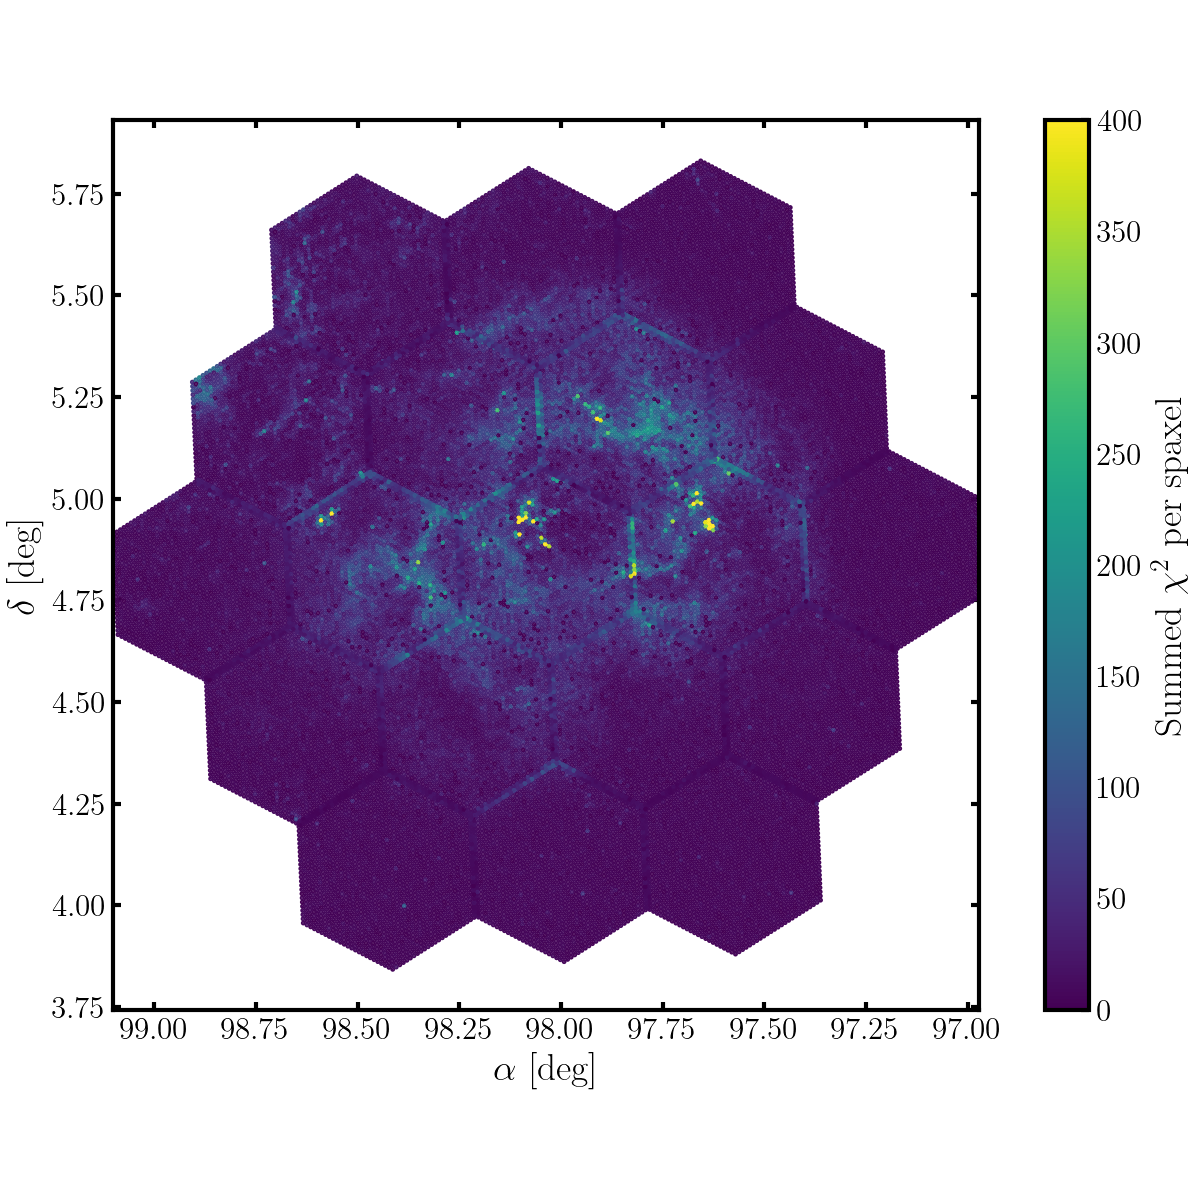

In [16]:
pred_flux = jax.vmap(pred_model, in_axes=(0, None))(fd.λ - LINE_CENTRE, fd.αδ_data)

χ2 = (fd.flux - pred_flux) ** 2 * fd.i_var

fig, ax = plt.subplots(figsize=[8, 8], layout="compressed", dpi=150)
cs = ax.scatter(
    fd.predict_α(fd.α), fd.predict_δ(fd.δ), c=np.sum(χ2, axis=0), s=0.7, vmin=0, vmax=400
)
plt.colorbar(cs, ax=ax, label=r"Summed $\chi^2$ per spaxel")
ax.set_xlabel(r"$\alpha$ [deg]")
ax.set_ylabel(r"$\delta$ [deg]")
ax.set_xlim(fd.predict_α(fd.α).max(), fd.predict_α(fd.α).min())
ax.set_aspect(1)
plt.show()

In the above we can see some structure, so the model isn't capturing everything. Maybe it's kurtosis? Maybe we could optimise for longer? 

What about our per-spaxel constant offset nuisance parameters?

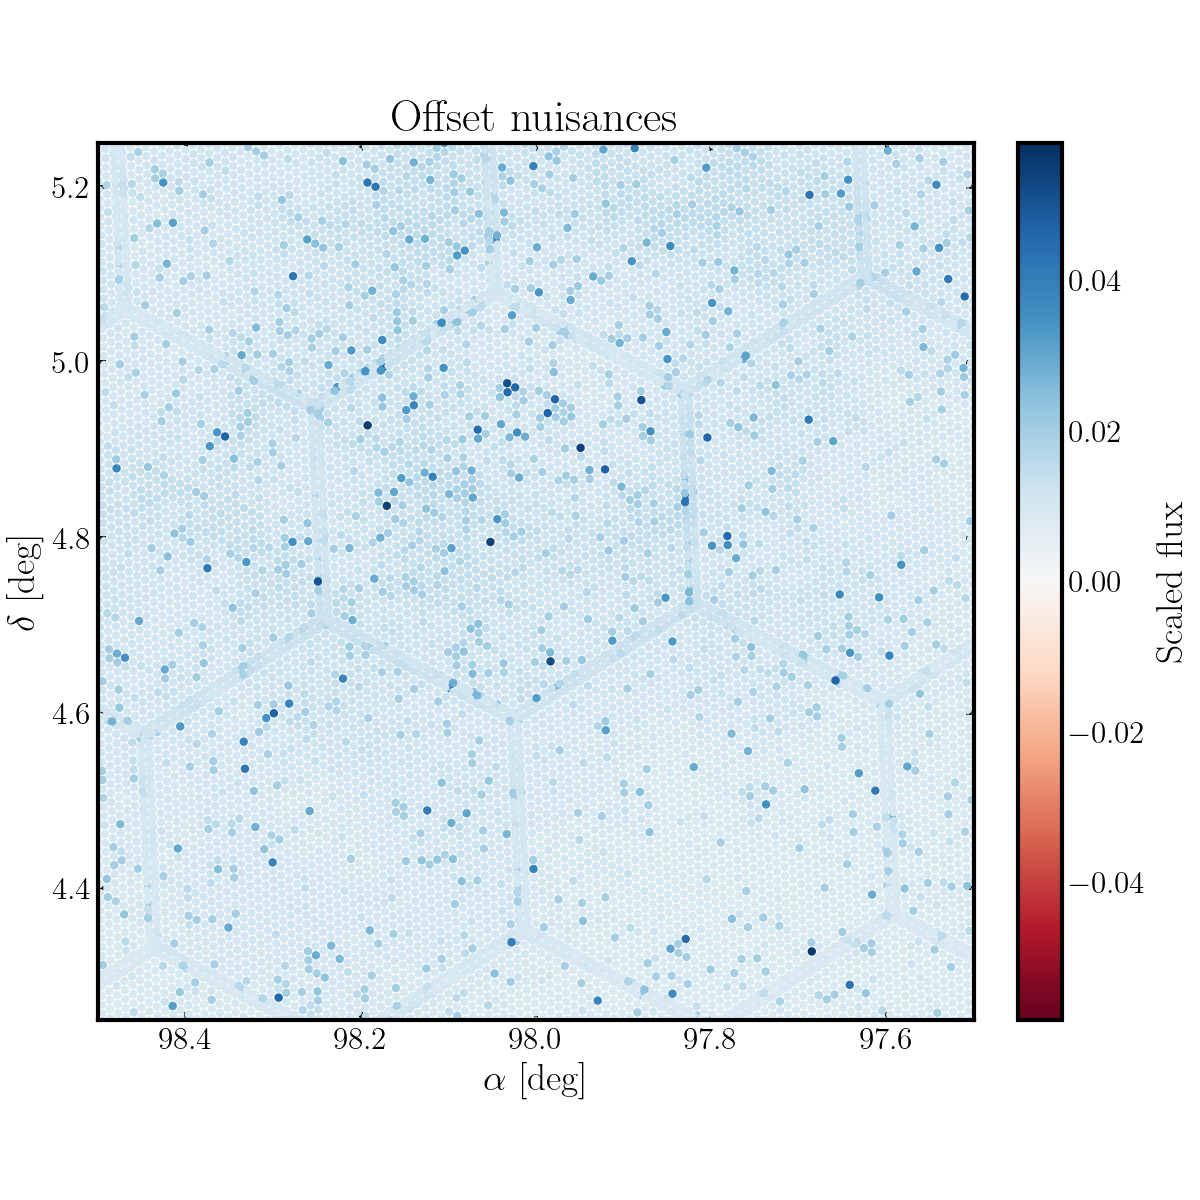

In [17]:
offsets = pred_model.continuum.const.spaxel_values.val

fig, ax = plt.subplots(figsize=[8, 8], layout="compressed", dpi=150)
ax.set_title("Offset nuisances")
cs = ax.scatter(
    fd.predict_α(fd.α),
    fd.predict_δ(fd.δ),
    c=offsets,
    s=6.5,
    vmin=-offsets.max(),
    vmax=offsets.max(),
    cmap="RdBu",
)
plt.colorbar(cs, ax=ax, label=r"Scaled flux")
ax.set_xlabel(r"$\alpha$ [deg]")
ax.set_ylabel(r"$\delta$ [deg]")
ax.set_xlim(fd.predict_α(fd.α).max(), fd.predict_α(fd.α).min())
ax.set_ylim(fd.predict_δ(fd.δ).min(), fd.predict_δ(fd.δ).max())

ax.set_xlim(98.5, 97.5)
ax.set_ylim(4.25, 5.25)

ax.set_aspect(1)
plt.show()